# [OpenCV-Python Tutorial] Classification

In this notebook, we will learn how to perform Object Classification using Visual Bag of Words(VBoW), spatial histogram feature, and SVM classifier.

---

In [1]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement opencv-python==3.4.2.17 (from versions: 3.4.0.14, 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.14.51, 3.4.14.53, 3.4.15.55, 3.4.16.57, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.2.52, 4.5.2.54, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68, 4.7.0.72)
ERROR: No matching distribution found for opencv-python==3.4.2.17
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement opencv-contrib-python==3.4.2.17 (from versions: 3.4.11.45, 3.4.13.47, 3.4.14.51, 3.4.14.53, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.4.0.46, 4.5.1.48, 4.5.2.52, 4.5.2.54, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66,

In [2]:
import os, sys
import tarfile
import time
import random
import pickle
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# download dataset
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp" -O 101_ObjectCategories.tar.gz && rm -rf /tmp/cookies.txt


--2023-03-26 05:17:20--  https://docs.google.com/uc?export=download&confirm=t&id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
Resolving docs.google.com (docs.google.com)... 142.251.2.102, 142.251.2.139, 142.251.2.100, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-24-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2es2ojfjbcatn4vmk8c3v15ikerg53f4/1679807775000/15424859768005087218/*/137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp?e=download&uuid=2d024741-eba5-4ea1-b128-0008f86a32ff [following]
--2023-03-26 05:17:20--  https://doc-00-24-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2es2ojfjbcatn4vmk8c3v15ikerg53f4/1679807775000/15424859768005087218/*/137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp?e=download&uuid=2d024741-eba5-4ea1-b128-0008f86a32ff
Resolving doc-00-24-docs.googleusercontent.com (doc-00-24-docs.googleusercontent.com)... 142.251.2.132, 2607:

In [4]:
caltech_url = 'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'
caltech_filename = '101_ObjectCategories.tar.gz'
caltech_dir = '101_ObjectCategories/'

numTrain = 15
numTest = 15
numClasses = 102
numWords = 600

vocabPath = 'vocab.pkl'
svmPath = os.path.join(caltech_dir, 'svm_data.dat')

# Dataset

## 1. Download Caltech-101 dataset

In [5]:
if not os.path.exists(caltech_dir) or not os.path.exists(os.path.join(caltech_dir, 'airplanes')):
    print('Extracting Caltech-101')
    with tarfile.open(caltech_filename) as tar:
        tar.extractall()

print('Caltech-101 dataset checked')

Extracting Caltech-101
Caltech-101 dataset checked


## 2. Setup Data

# Dense SIFT(PHOW) and Visual Words

Select 15 train/test images for each class
done


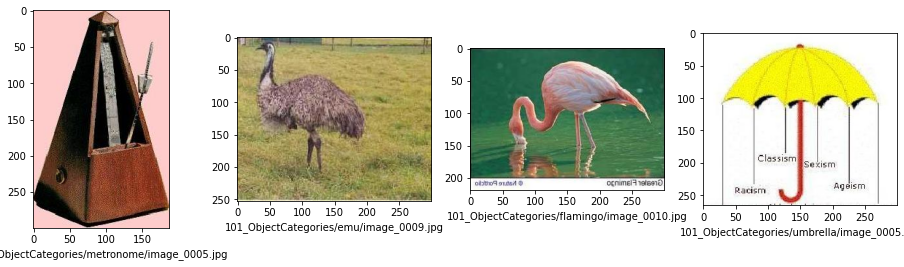

In [6]:
# Select 15 train/test images for each class
print('Select 15 train/test images for each class')
classes = next(os.walk(caltech_dir))[1]
train_image_ll = []
test_image_ll = []
for c in classes:
    class_dir = os.path.join(caltech_dir, c, '*.jpg')
    ims = glob(class_dir)
    ims.sort()
    train_image_ll.append([f for f in ims[:numTrain]])
    test_image_ll.append([f for f in ims[numTrain:numTrain+numTest]])
print('done')

# Show 4 random images
plt.figure(figsize=(16,4))
for i, idx in enumerate(random.sample(range(len(classes)), 4)):
    fpath = random.sample(train_image_ll[idx], 1)[0]
    plt.subplot(1, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel(fpath)

## 1. SIFT helper functions

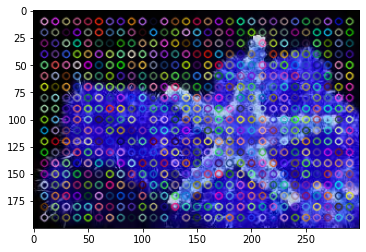

In [7]:
sift = cv2.xfeatures2d.SIFT_create()

# Resize a image if it's too large
def standarizeImage(img):
    rows, cols = img.shape
    if cols > 480:
        img = cv2.resize(img, (480, int(rows*480/cols)))
    return img

# Detect and extract SIFT from a single image
def SIFT(img):
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

# Load an image + Resize if large + Extract SIFT
def SIFT2(img_fpath):
    img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)
    img = standarizeImage(img)
    return SIFT(img)

# Dense SIFT(Extract SIFT descriptor in grid points over an image)
def denseSIFT(img, step = 10, size = 7):
    rows, cols = img.shape[:2]
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    return kp, des

# Load an image + Resize if large + Dense SIFT
def denseSIFT2(img_fpath, step = 10):
    img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)
    img = standarizeImage(img)
    return denseSIFT(img, step)

# Dense SIFT
tmp_im = cv2.cvtColor(cv2.imread(train_image_ll[0][0]), cv2.COLOR_BGR2RGB)
#kp, des = SIFT(tmp_im)
kp, des = denseSIFT(tmp_im)
im_sift = cv2.drawKeypoints(tmp_im, kp, None)
plt.imshow(cv2.cvtColor(im_sift, cv2.COLOR_BGR2RGB))

## 2. Visual Words(Train Vocabulary)

In [8]:
# Download pre-extracted vocab.pkl
!wget https://raw.githubusercontent.com/bckim92/iab_practice_example/master/vocab.pkl

--2023-03-26 05:17:36--  https://raw.githubusercontent.com/bckim92/iab_practice_example/master/vocab.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 307361 (300K) [application/octet-stream]
Saving to: ‘vocab.pkl’

vocab.pkl           100%[===================>] 300.16K  --.-KB/s    in 0.02s   

2023-03-26 05:17:36 (14.3 MB/s) - ‘vocab.pkl’ saved [307361/307361]



In [9]:
# Train vocabulary
if os.path.exists(vocabPath):
    # Get PHOW features from 30 random training image to build a dictionary
    print("Extracting PHOW features some training images...")
    PHOW_descrs = []
    temp = [item for sublist in train_image_ll for item in sublist]
    temp = random.sample(temp, 30)
    for fpath in temp:
        _, des = denseSIFT2(fpath)
        PHOW_descrs.append(des)
    PHOW_descrs = np.concatenate(PHOW_descrs, axis=0)
    print("Total {} PHOW features".format(PHOW_descrs.shape[0]))
    
    # Quantize the descriptors to get the visual words
    print("Running K-means clustering ({} -> {})...".format(PHOW_descrs.shape[0], numWords))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 1.0)
    attempts = 10
    flags = cv2.KMEANS_RANDOM_CENTERS
    start_time = time.time()
    retval, bestLabels, vocab = cv2.kmeans(PHOW_descrs, numWords, None, criteria, attempts, flags)
    print('Elapsed time: {:6}s'.format(time.time() - start_time))
    
    print('Saving...') 
    with open(vocabPath, 'wb') as fd:
        pickle.dump(vocab, fd)
else:
    print("Load the trained visual words...")
    with open(vocabPath, 'rb') as fd:
        vocab = pickle.load(fd)

print('Done!')

Extracting PHOW features some training images...
Total 19802 PHOW features
Running K-means clustering (19802 -> 600)...
Elapsed time: 235.6341643333435s
Saving...
Done!


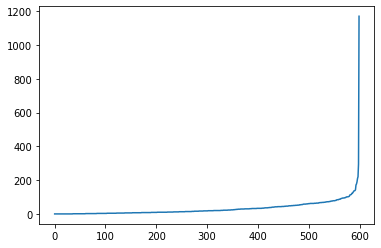

In [10]:
import collections
myCounter = collections.Counter(bestLabels.flatten())
plt.plot(sorted(myCounter.values()))

# Classification - SVM

## Spatial Histogram

In [11]:
bf = cv2.BFMatcher()
# 영상 정합을 위한 matching과정에서 쓰이는 함수다.
def getImageDescriptor(img, step=10, size=7):
    img = standarizeImage(img)
    cols, rows = img.shape[:2]
    
    # Extracting denseSIFT and BoW
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    matches = bf.knnMatch(des, vocab, k=1)
    words = [m[0].trainIdx for m in matches]
    
    # Spatial Binning - 2x2
    binX = 2; binY = 2;
    temp = np.zeros((binX, binY, numWords), dtype=np.float32)
    for k, w in zip(kp, words):
        i = int((k.pt[0]) * binX / cols)
        j = int((k.pt[1]) * binY / rows)
        temp[i, j, w] += 1
    for i in range(binX):
        for j in range(binY):
            temp[i, j, :] /= np.sum(temp[i, j, :])
    temp = temp.flatten()
    hist = temp
    
    # Spatial Binning - 4x4
    ################################
    # TODO : your code here
    temp = []
    binX = 4; binY = 4;
    temp = np.zeros((binX, binY, numWords), dtype=np.float32)
    for k, w in zip(kp, words):
        i = int((k.pt[0]) * binX / cols)
        j = int((k.pt[1]) * binY / rows)
        temp[i, j, w] += 1
    for i in range(binX):
        for j in range(binY):
            temp[i, j, :] /= np.sum(temp[i, j, :])
    temp = temp.flatten()
    hist = temp



    ################################
    hist = np.concatenate((hist, temp), axis=0)
    
    hist /= np.sum(hist)
    return hist    

## 1. Genarate spatial histogram for Training Images

In [12]:
# Extract spartial histogram for all training images
print('Extract spartial histogram for all training images')
BoW_train_ll = []
for c, image_list in zip(classes, train_image_ll):
    print(c, end=' '), 
    temp = []
    for fpath in image_list:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        temp.append(getImageDescriptor(img))
    BoW_train_ll.append(temp)

print('\ndone!')

Extract spartial histogram for all training images
starfish okapi panda elephant snoopy grand_piano euphonium Motorbikes Faces watch laptop trilobite accordion cougar_face bass chair crab wild_cat anchor ant airplanes rooster beaver gramophone ewer dollar_bill flamingo_head wrench car_side pigeon dolphin brontosaurus crocodile menorah Faces_easy schooner platypus mayfly wheelchair lotus revolver metronome gerenuk scorpion ceiling_fan yin_yang rhino kangaroo llama dalmatian pyramid pagoda strawberry chandelier barrel joshua_tree octopus umbrella cellphone dragonfly butterfly inline_skate minaret sea_horse soccer_ball lobster cougar_body windsor_chair stop_sign hedgehog ferry saxophone camera sunflower water_lilly nautilus BACKGROUND_Google ibis bonsai cup cannon buddha lamp binocular mandolin emu tick electric_guitar pizza Leopards headphone crocodile_head crayfish stapler hawksbill garfield brain scissors stegosaurus flamingo ketch helicopter 
done!


## 2. Train SVM

In [13]:
# Setting training data(BoW, label) for SVM
print('Setting training data(BoW, label) for SVM')
train_bow = []
train_labels = []
numSpartialHist = len(BoW_train_ll[0][0])
for i, BoW_list in enumerate(BoW_train_ll):
    for bow in BoW_list:
        # Hellinger's kernel for each training instance(bow)
        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp /= np.std(temp)
        train_bow.append([temp])
    train_labels.extend([i] * len(BoW_list))
train_bow = np.concatenate(train_bow, axis=0).astype(np.float32)
train_labels = np.array(train_labels, dtype=np.int).reshape((numTrain*numClasses,1))
# => train_bow: (1530, 12000), train_labels: (1530,1)

print("train_bow: ", str(train_bow.shape))
print("train_labels: ", str(train_labels.shape))

Setting training data(BoW, label) for SVM
train_bow:  (1530, 19200)
train_labels:  (1530, 1)


<ipython-input-13-3233277be65d>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array(train_labels, dtype=np.int).reshape((numTrain*numClasses,1))


In [14]:
# Train SVM
print('Training SVM...')
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setC(0.01)
svm.setTermCriteria((cv2.TERM_CRITERIA_COUNT, 10, 1.0))

start_time = time.time()
# svm.train(SVM_train_data)
svm.train(train_bow, cv2.ml.ROW_SAMPLE, train_labels)
print('Elapsed time: {:6}s'.format(time.time() - start_time))

# print 'Saving SVM...'
# svm.save(svmPath)
print('Done!')

Training SVM...
Elapsed time: 43.416536808013916s
Done!


In [15]:
train_preds = svm.predict(train_bow)[1]
print('Training Accuracy: %.6f' % np.average(train_preds == train_labels))

Training Accuracy: 0.986275


## 3. Test trained SVM

In [16]:
# Extract spartial histogram for all test images
################################
# TODO : your code here
print('Extract spartial histogram for all test images')
BoW_test_ll = []
for c, image_list in zip(classes, test_image_ll):
    print(c, end=' '), 
    temp = []
    for fpath in image_list:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        temp.append(getImageDescriptor(img))
    BoW_test_ll.append(temp)

print('\ndone!')
################################

Extract spartial histogram for all test images
starfish okapi panda elephant snoopy grand_piano euphonium Motorbikes Faces watch laptop trilobite accordion cougar_face bass chair crab wild_cat anchor ant airplanes rooster beaver gramophone ewer dollar_bill flamingo_head wrench car_side pigeon dolphin brontosaurus crocodile menorah Faces_easy schooner platypus mayfly wheelchair lotus revolver metronome gerenuk scorpion ceiling_fan yin_yang rhino kangaroo llama dalmatian pyramid pagoda strawberry chandelier barrel joshua_tree octopus umbrella cellphone dragonfly butterfly inline_skate minaret sea_horse soccer_ball lobster cougar_body windsor_chair stop_sign hedgehog ferry saxophone camera sunflower water_lilly nautilus BACKGROUND_Google ibis bonsai cup cannon buddha lamp binocular mandolin emu tick electric_guitar pizza Leopards headphone crocodile_head crayfish stapler hawksbill garfield brain scissors stegosaurus flamingo ketch helicopter 
done!


In [17]:
# Setting test data(BoW, label) for SVM
print('Setting test data(BoW, label) for SVM')
################################

# TODO : your code here
test_bow = []
test_labels = []
numSpartialHist = len(BoW_test_ll[0][0])

for i, BoW_list in enumerate(BoW_train_ll):
    for bow in BoW_list:
        # Hellinger's kernel for each training instance(bow)
        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp /= np.std(temp)
        test_bow.append([temp])
    test_labels.extend([i] * len(BoW_list))
test_bow = np.concatenate(test_bow, axis=0).astype(np.float32)
test_labels = np.array(test_labels, dtype=np.int).reshape((numTrain*numClasses,1))
print(test_labels)
# => test_bow: (1530, 19200), test_labels: (1530,1)


# TODO : inference code here
# 위의 train코드처럼 test 코드도 비슷한 식으로 만들었다.




print(test_bow.shape)
print(test_labels.shape)
################################

Setting test data(BoW, label) for SVM
[[  0]
 [  0]
 [  0]
 ...
 [101]
 [101]
 [101]]
(1530, 19200)
(1530, 1)


<ipython-input-17-f04b680aa61c>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_labels = np.array(test_labels, dtype=np.int).reshape((numTrain*numClasses,1))


In [18]:
test_preds = svm.predict(test_bow)[1]
print('Test Accuracy: {:6}'.format(np.average(test_preds == test_labels)))


Test Accuracy: 0.9862745098039216


## 4. Sample Results

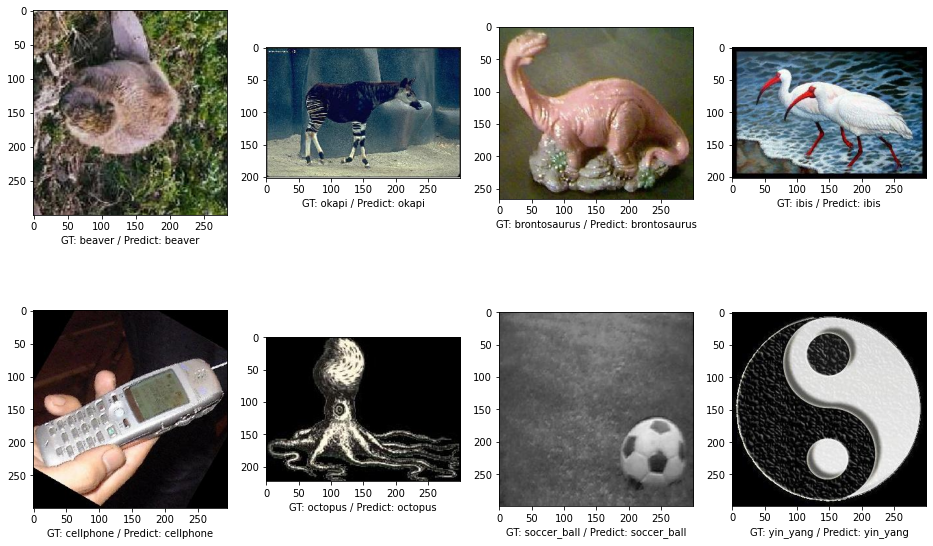

In [19]:
# Show 8 random images
plt.figure(figsize=(16,10))
for i, r_c in enumerate(random.sample(range(len(classes)), 8)):
    # Random sample image from given class
    r_i = random.sample(range(numTest), 1)#[0부터14까지 임의의 수를 꺼냄]
    fpath = train_image_ll[r_c][r_i[0]]
    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)

    # Get predicted label
    test_res = int(test_preds[r_c * numTest + r_i[0]][0])

    plt.subplot(2, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel("GT: {} / Predict: {}".format(classes[r_c], classes[test_res]))

# Practice: Classify your own image

Choose and classify your own test image using our classification.

- Place your image in the path where this notebook can access
- Load an image as grayscale
- Extract Dense SIFT BoW with `getImageDescriptor()`
- Normalize the bow with Hellinger's kernel
- Predict using the SVM classifier we have trained so far(`svm` instance)

In [20]:
!wget https://raw.githubusercontent.com/bckim92/iab_practice_example/master/images/dragonfly.jpg

--2023-03-26 05:28:13--  https://raw.githubusercontent.com/bckim92/iab_practice_example/master/images/dragonfly.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23885 (23K) [image/jpeg]
Saving to: ‘dragonfly.jpg’

dragonfly.jpg       100%[===================>]  23.33K  --.-KB/s    in 0s      

2023-03-26 05:28:13 (47.0 MB/s) - ‘dragonfly.jpg’ saved [23885/23885]



Text(0.5, 0, 'Prediction: ceiling_fan')

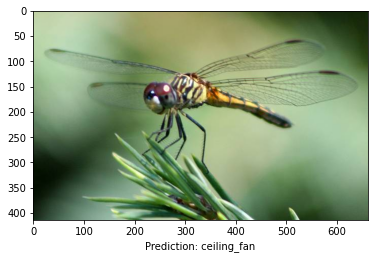

In [32]:
img_fpath = './dragonfly.jpg'  # Path to your own image Place your image in the path where this notebook can access 완료.
img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)#Load an image as grayscale 완료

#================ YOUR CODE HERE ===================
temp1 = []
temp1.append(getImageDescriptor(img))
BoW_test_ll = []#[[]]
BoW_test_ll.append(temp1)#잠자리 사진만 들어간 bow_test_ll를 만듬.

#print(BoW_test_ll)#[[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)]]

# Setting test data(BoW, label) for SVM
test_bow = []
# test_bow.append([temp1])#[[[]]]

for i, BoW_list in enumerate(BoW_test_ll):
    for bow in BoW_list:
        # Hellinger's kernel for each training instance(bow) 정규화함.
        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp /= np.std(temp)
        test_bow.append([temp])



test_bow = np.concatenate(test_bow, axis=0).astype(np.float32)
#이걸 하면 print(test_bow)는 [[-0.16681576 -0.16681576 -0.16681576 ... -0.16681576 -0.16681576,  -0.16681576]]

test_preds = svm.predict(test_bow)[1]
#print(test_preds) #[[44.]] 44번 class로 분류되는데, 이는 ceiling_fan이다.
#print(test_bow)
prediction = int(test_preds)

# print(classes) : ['starfish', 'okapi', 'panda', 'elephant', 'snoopy', 'grand_piano'...]

#===================================================

plt.imshow(cv2.cvtColor(cv2.imread(img_fpath), cv2.COLOR_BGR2RGB))
plt.xlabel("Prediction: {}".format(classes[prediction]))

In [34]:
# Desired output 
# dragonfly가 나와야 하는데 ceiling fan(천장에 붙은 환풍구 팬)이 나왔다.
# 잠자리의 날개가 유사한 ceiling fan의 바람개비 쪽 부분을 구분을 못하여 생기는 문제라고 볼 수 있다.
# 이는 좀 더 많은 자료를 갖고 training을 하면 구분할 수 있을 것으로 추측한다. 
# 아래 코드에 추가로 인터넷에서 dragonfly image를 갖고와서 더 시도해 보았는데 이번에는 chandelier(샹들리에)로 구분한다.

In [36]:
!wget https://dragonflywoman.files.wordpress.com/2009/05/anax-adult-scan.jpg?w=640

--2023-03-26 05:48:51--  https://dragonflywoman.files.wordpress.com/2009/05/anax-adult-scan.jpg?w=640
Resolving dragonflywoman.files.wordpress.com (dragonflywoman.files.wordpress.com)... 192.0.72.24, 192.0.72.25
Connecting to dragonflywoman.files.wordpress.com (dragonflywoman.files.wordpress.com)|192.0.72.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67221 (66K) [image/jpeg]
Saving to: ‘anax-adult-scan.jpg?w=640’

anax-adult-scan.jpg 100%[===================>]  65.65K  --.-KB/s    in 0.02s   

2023-03-26 05:48:51 (4.14 MB/s) - ‘anax-adult-scan.jpg?w=640’ saved [67221/67221]



Text(0.5, 0, 'Prediction: chandelier')

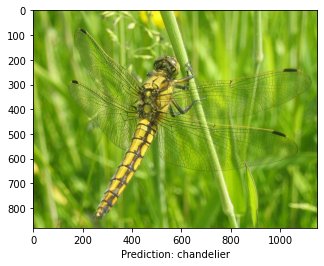

In [41]:
img_fpath = './Orthetrum_cancellatum.jpg'  # Path to your own image Place your image in the path where this notebook can access 완료.
img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)#Load an image as grayscale 완료


#================ YOUR CODE HERE ===================
temp2 = []
temp2.append(getImageDescriptor(img))
BoW_test_ll = []#[[]]
BoW_test_ll.append(temp2)#잠자리 사진만 들어간 bow_test_ll를 만듬.

#print(BoW_test_ll)#[[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)]]

# Setting test data(BoW, label) for SVM
test_bow = []
# test_bow.append([temp1])#[[[]]]

for i, BoW_list in enumerate(BoW_test_ll):
    for bow in BoW_list:
        # Hellinger's kernel for each training instance(bow) 정규화함.
        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp /= np.std(temp)
        test_bow.append([temp])



test_bow = np.concatenate(test_bow, axis=0).astype(np.float32)
#이걸 하면 print(test_bow)는 [[-0.16681576 -0.16681576 -0.16681576 ... -0.16681576 -0.16681576,  -0.16681576]]

test_preds = svm.predict(test_bow)[1]
#print(test_preds) #[[44.]] 44번 class로 분류되는데, 이는 ceiling_fan이다.
#print(test_bow)
prediction = int(test_preds)

# print(classes) : ['starfish', 'okapi', 'panda', 'elephant', 'snoopy', 'grand_piano'...]

#===================================================

plt.imshow(cv2.cvtColor(cv2.imread(img_fpath), cv2.COLOR_BGR2RGB))
plt.xlabel("Prediction: {}".format(classes[prediction]))